<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>MCMC </font></h3>
    
    MCMCの計算を行うコードを実行しています。
    Persuasive Python by Adam Fleischhacker 
    https://www.persuasivepython.com/
    
    のコードをライセンスに従って使用しています。
  

/tmp/ipykernel_42/3085080301.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


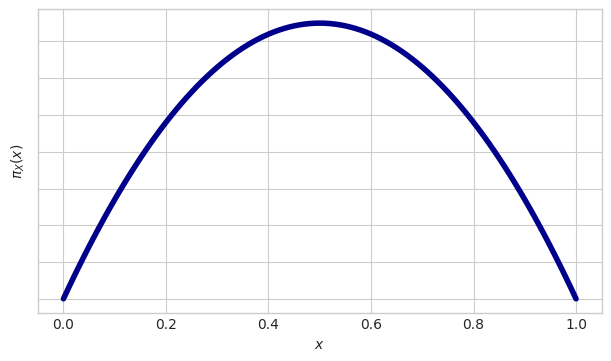

In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

def pi_X(x):
    if x >= 0 and x <= 1:
        return 6*x*(1-x)
    
    else:
        return 0

x = [i/100 for i in range(101)]
y = [pi_X(i) for i in x]

fig, ax = plt.subplots(figsize=(6, 3.5), layout='constrained')
ax.plot(x, y, color='darkblue', linewidth=4)
ax.set(xlabel=r'$x$', ylabel=r'$\pi_X(x)$')
ax.set_yticklabels([])

plt.show();

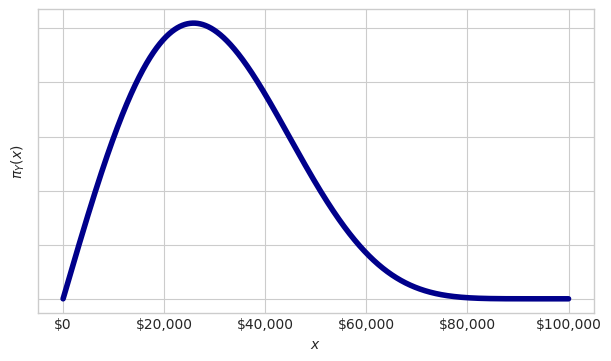

In [4]:
from matplotlib.ticker import FuncFormatter

def pi_Y(y):
    kumaRealization = y / 100000
    jacobian = 1 / 10**5
    if kumaRealization >= 0 and kumaRealization <= 1:
        return 2*8*kumaRealization*(1-kumaRealization**2)**7*jacobian
    else:
        return 0
    
def dollar_format(x, pos):
    """Format y-axis tick Labels in dollar format"""
    return '${:,.0f}'.format(x)

x = [i for i in range(100001)]
y = [pi_Y(i) for i in x]

fig, ax = plt.subplots(figsize=(6, 3.5), layout='constrained')
ax.plot(x, y, color='darkblue', linewidth=4)
ax.set(xlabel=r'$x$', ylabel=r'$\pi_Y(x)$')
ax.xaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_yticklabels([])

plt.show()

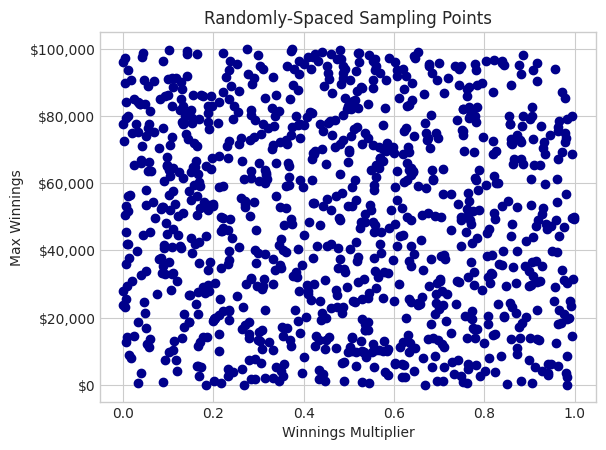

In [7]:
import pandas as pd
import numpy as np

N = 1000 ## 1000でのサンプル

gridDF = pd.DataFrame({'winningsMultiplier': np.random.rand(N),
                       'maxWinnings': 10**5*np.random.rand(N)})

fig, ax = plt.subplots()
ax.scatter(gridDF['winningsMultiplier'], gridDF['maxWinnings'], color='darkblue')
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))

# 軸ラベルとタイトルを設定
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Randomly-Spaced Sampling Points')

plt.show()